# _Работа 7:_ Отравление ядерного реактора

In [53]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import pyGetera

Зададим ячейки:

## Ячейка ВВЭР
Аналогичная ячкйке из работы 5 с обогащением $x=4.4 \%$

In [2]:
def vver_input():
    getera = pyGetera.GeteraInterface(
        getera_path='D:\\bin\\',
        input_file='lab7VVER.txt',
        output_file='lab7VVER.out')
    
    ptop0 = 10.97*6.02*10**(23)/269.928
    pzam01 = 0.7*6.02*10**(23)/18.015
    
    Rho1 = pd.DataFrame({'x':[3.6, 4.4]})
    Rho1['pzam'] = pzam01
    Rho1['ptop'] = ptop0
    Rho1['u235'] = (Rho1.x/100)*Rho1.ptop*10**(-24)
    Rho1['u238'] = (1-Rho1.x/100)*Rho1.ptop*10**(-24)
    Rho1['o']    = 2*Rho1.ptop*10**(-24)
    Rho1['zr']   = 0.0351
    Rho1['h']    = 2*Rho1.pzam*10.97**(-24)
    Rho1['*o*']  = Rho1.pzam*10**(-24)
    
    Rcell = 0.5
    d = 0.6
    delta_t = 0.05
    
    
    getera.input({
            'r':    [d/2 - delta_t,   d/2,            0.4],
            'u235': [Rho1['u235'][1], 0,              0],
            'u238': [Rho1['u238'][1], 0,              0],
            'o':    [Rho1['o'][1],    0,              0],
            'zr':   [0,               Rho1['zr'][0],  0],
            'h':    [0,               0,              Rho1['h'][1]],
            '*o*':  [0,               0,              Rho1['*o*'][1]]
    })
    
    a = parse_out(getera)
    return a

def parse_out(getera):
    val = pd.DataFrame(getera.output(isotope=['xe35'], columns=['keff', 'ρ(xe35)']))
    
    return val

## Ячейка РБМК
Аналогична ячейке из работы 6, с графитом в качестве замедлителя, водой в качестве теплоносителя и обогащением $x=2.4\%$

In [65]:
def rbmk_input():
    getera = pyGetera.GeteraInterface(
        getera_path='D:\\bin\\',
        input_file='lab7RBMK.txt',
        output_file='lab7RBMK.out')
    
    
    ptop0 = 10.97*6.02*10**(23)/269.928
    pcool = 0.7*6.02*10**(23)/18.015
    pzam01 = 1.67*6.02*10**(23)/12.011
    
    Rho1 = pd.DataFrame({'x':[2.4]})
    Rho1['pzam'] = pzam01
    Rho1['ptop'] = ptop0
    Rho1['U235'] = (Rho1.x/100)*Rho1.ptop*10**(-24)
    Rho1['U238'] = (1-Rho1.x/100)*Rho1.ptop*10**(-24)
    Rho1['O']    = 2*Rho1.ptop*10**(-24)
    Rho1['Zr']   = 0.0351
    Rho1['*H*']  = 2*pcool*10.97**(-24)
    Rho1['*O*']  = pcool*10**(-24)
    Rho1['C']    = Rho1.pzam*10**(-24)
    Rho1['D']    = 0
    Acell = 12
    d = 1
    delta_t = 0.06
    TVS_R = 5
    delta_TVS = 0.25
    
    #меняем радиусы
    getera.input({
            'rcel(1,1)':[0.75],
            'rcel(1,2)':[d/2 - delta_t, d/2, 1],
            'rcel(1,3)':[5.0,5.6,6.5,9.,11.3, 16.5, 'rcin(3)=4.75'],
        }, reg_exp=r'\s+rcel\(\d,\d\)=')
        
        #меняем концентрации 
    getera.input({
            'u235': [Rho1['U235'][0], 0,              0,              0],
            'u238': [Rho1['U238'][0], 0,              0,              0],
            'o':    [Rho1['O'][0],    0,              0,              0],
            'zr':   [0,               Rho1['Zr'][0],  0,              0],
            '*h*':  [0,               0,              Rho1['*H*'][0], 0],
            '*o*':  [0,               0,              Rho1['*O*'][0], 0],
            'c':    [0,               0,              0,              Rho1['C'][0]]
        })
    
    a = parse_out(getera)
    return a 

Определим формулу для расчета концентрации ксенона после останова реактора

In [68]:
def rhoXeAfter(F, curr):
    sigmaaXe = 3.5e+6
    lambdaXe = np.log(2)/(9.14*60*60)
    lambdaJ = np.log(2)/(6.57*60*60)
    
    rho = lambda t, F: (np.exp(-1*lambdaXe*t) 
                + ((lambdaXe+sigmaaXe*F)*(np.exp(-1*lambdaJ*t) 
                - np.exp(-1*lambdaXe*t)))/(lambdaXe-lambdaJ))*10**(-24)
    return pd.DataFrame(zip([rho(t-5*24*60*60,F) + 
        curr for t in np.arange(5*24*60*60,7.25*24*60*60,0.25*24*60*60 )],
                            [0 for i in range(9)]),
        columns=['ρ(xe35)','keff'])

## Расчёт
Теперь найдем концентрации и коэффициенты при режимах:

* `50%,100%...` — режим 1
* `100%,...,50%,` — режим 2

предварительно изменив мощности в выходных файлах:

**ВВЭР: Режим 1** 

$q_v=55,110,110,110,110$

,0,1,2,3,4,5,6,7
keff,0.809670,0.808390,0.80691,0.80644,0.806190,0.000000,0.000000,0.000000
ρ(xe35),0.203478,0.686563,1.00000,1.04582,1.052776,1.053949,1.511039,1.164341


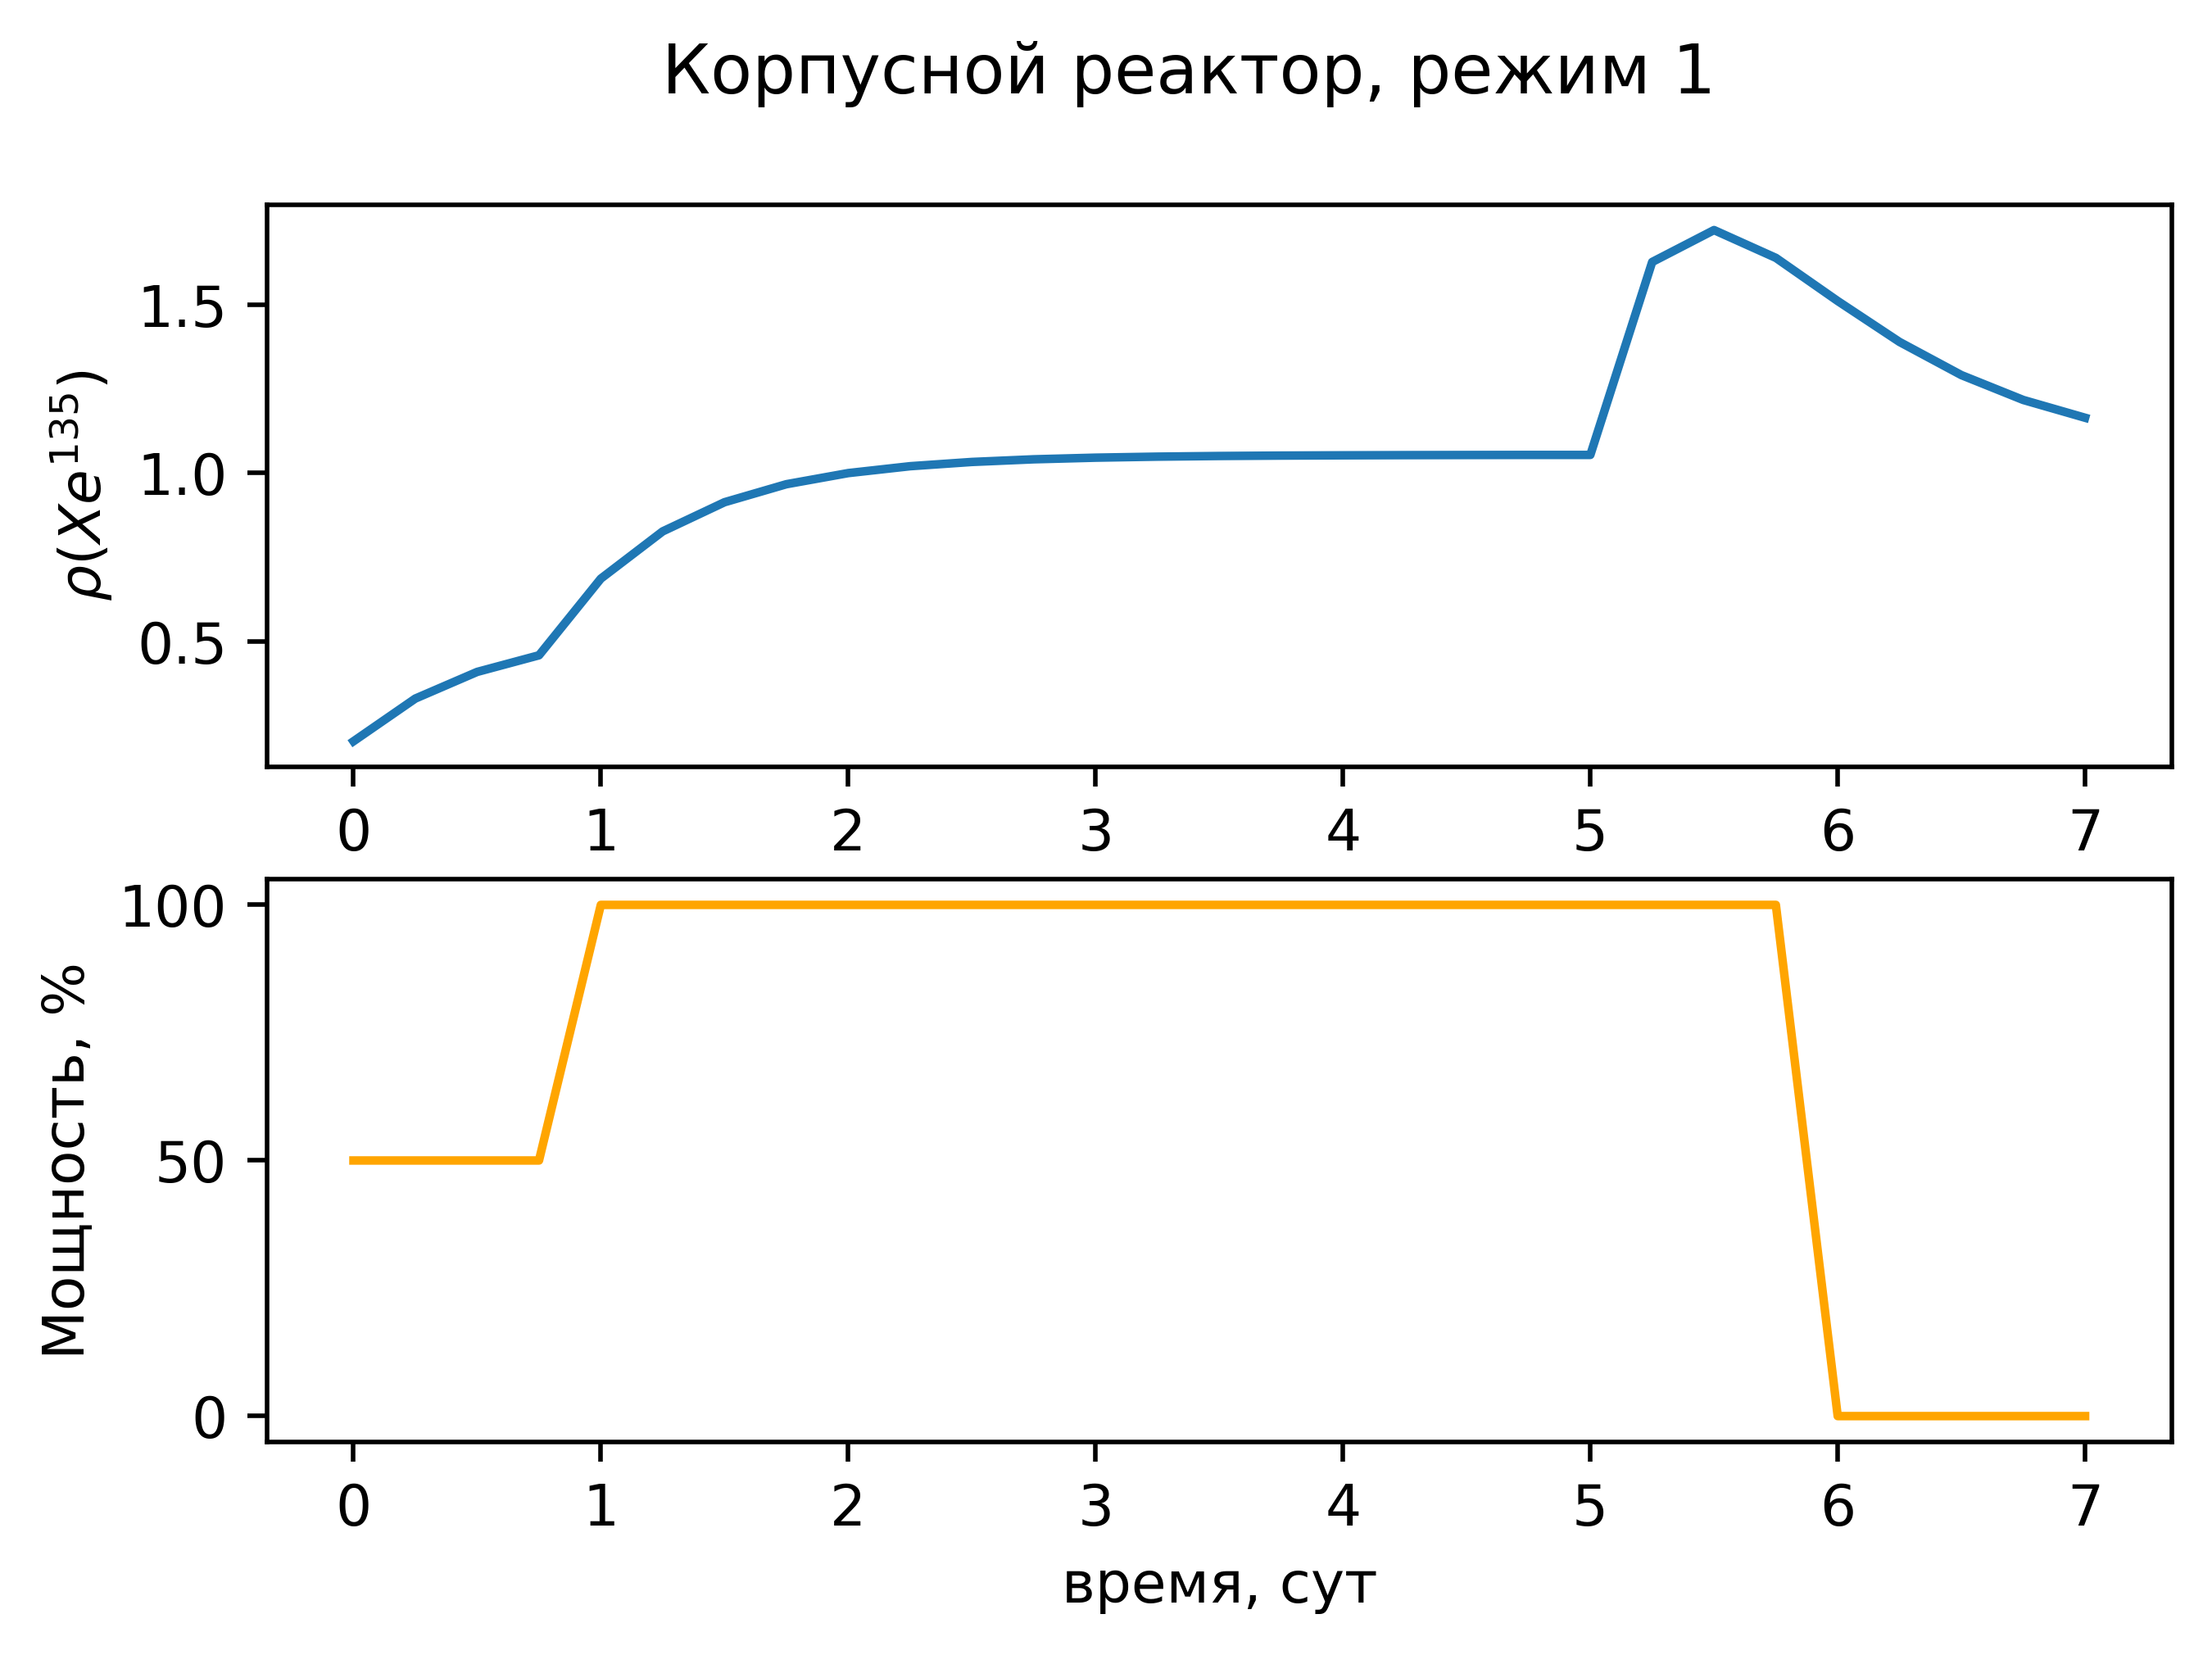

In [86]:
vver1 = vver_input()
F1 = 30000e+1
vver1_after_stopping = rhoXeAfter(F1, vver1['ρ(xe35)'][19]) 
p0 = pd.concat((vver1, vver1_after_stopping), axis = 0, ignore_index=True)
p0['ρ(xe35)'] /= p0['ρ(xe35)'][8]
p0v = p0[::4]
p0v.index = range(8)
display(p0v.T)

fig, (ax1, ax2) = pl.subplots(2)
fig.suptitle('Корпусной реактор, режим 1')
ax1.plot(p0.index/4, p0['ρ(xe35)'])
ax2.plot(p0.index/4, [50]*4+[100]*20+[0]*5, color='orange')
pl.xlabel('время, сут')
ax1.set_ylabel(r'$\rho(Xe^{135})$')
ax2.set_ylabel(r'Мощность, %')
fig.set_dpi(500)

**РБМК: Режим 1**

$q_v=2.25,4.5,4.5,4.5,4.5$

,0,1,2,3,4,5,6,7
keff,1.450200,1.408200,1.3989,1.397200,1.395400,0.000000,0.000000,0.000000
ρ(xe35),0.641144,0.985855,1.0000,0.999284,0.998785,0.998519,1.173494,1.040777


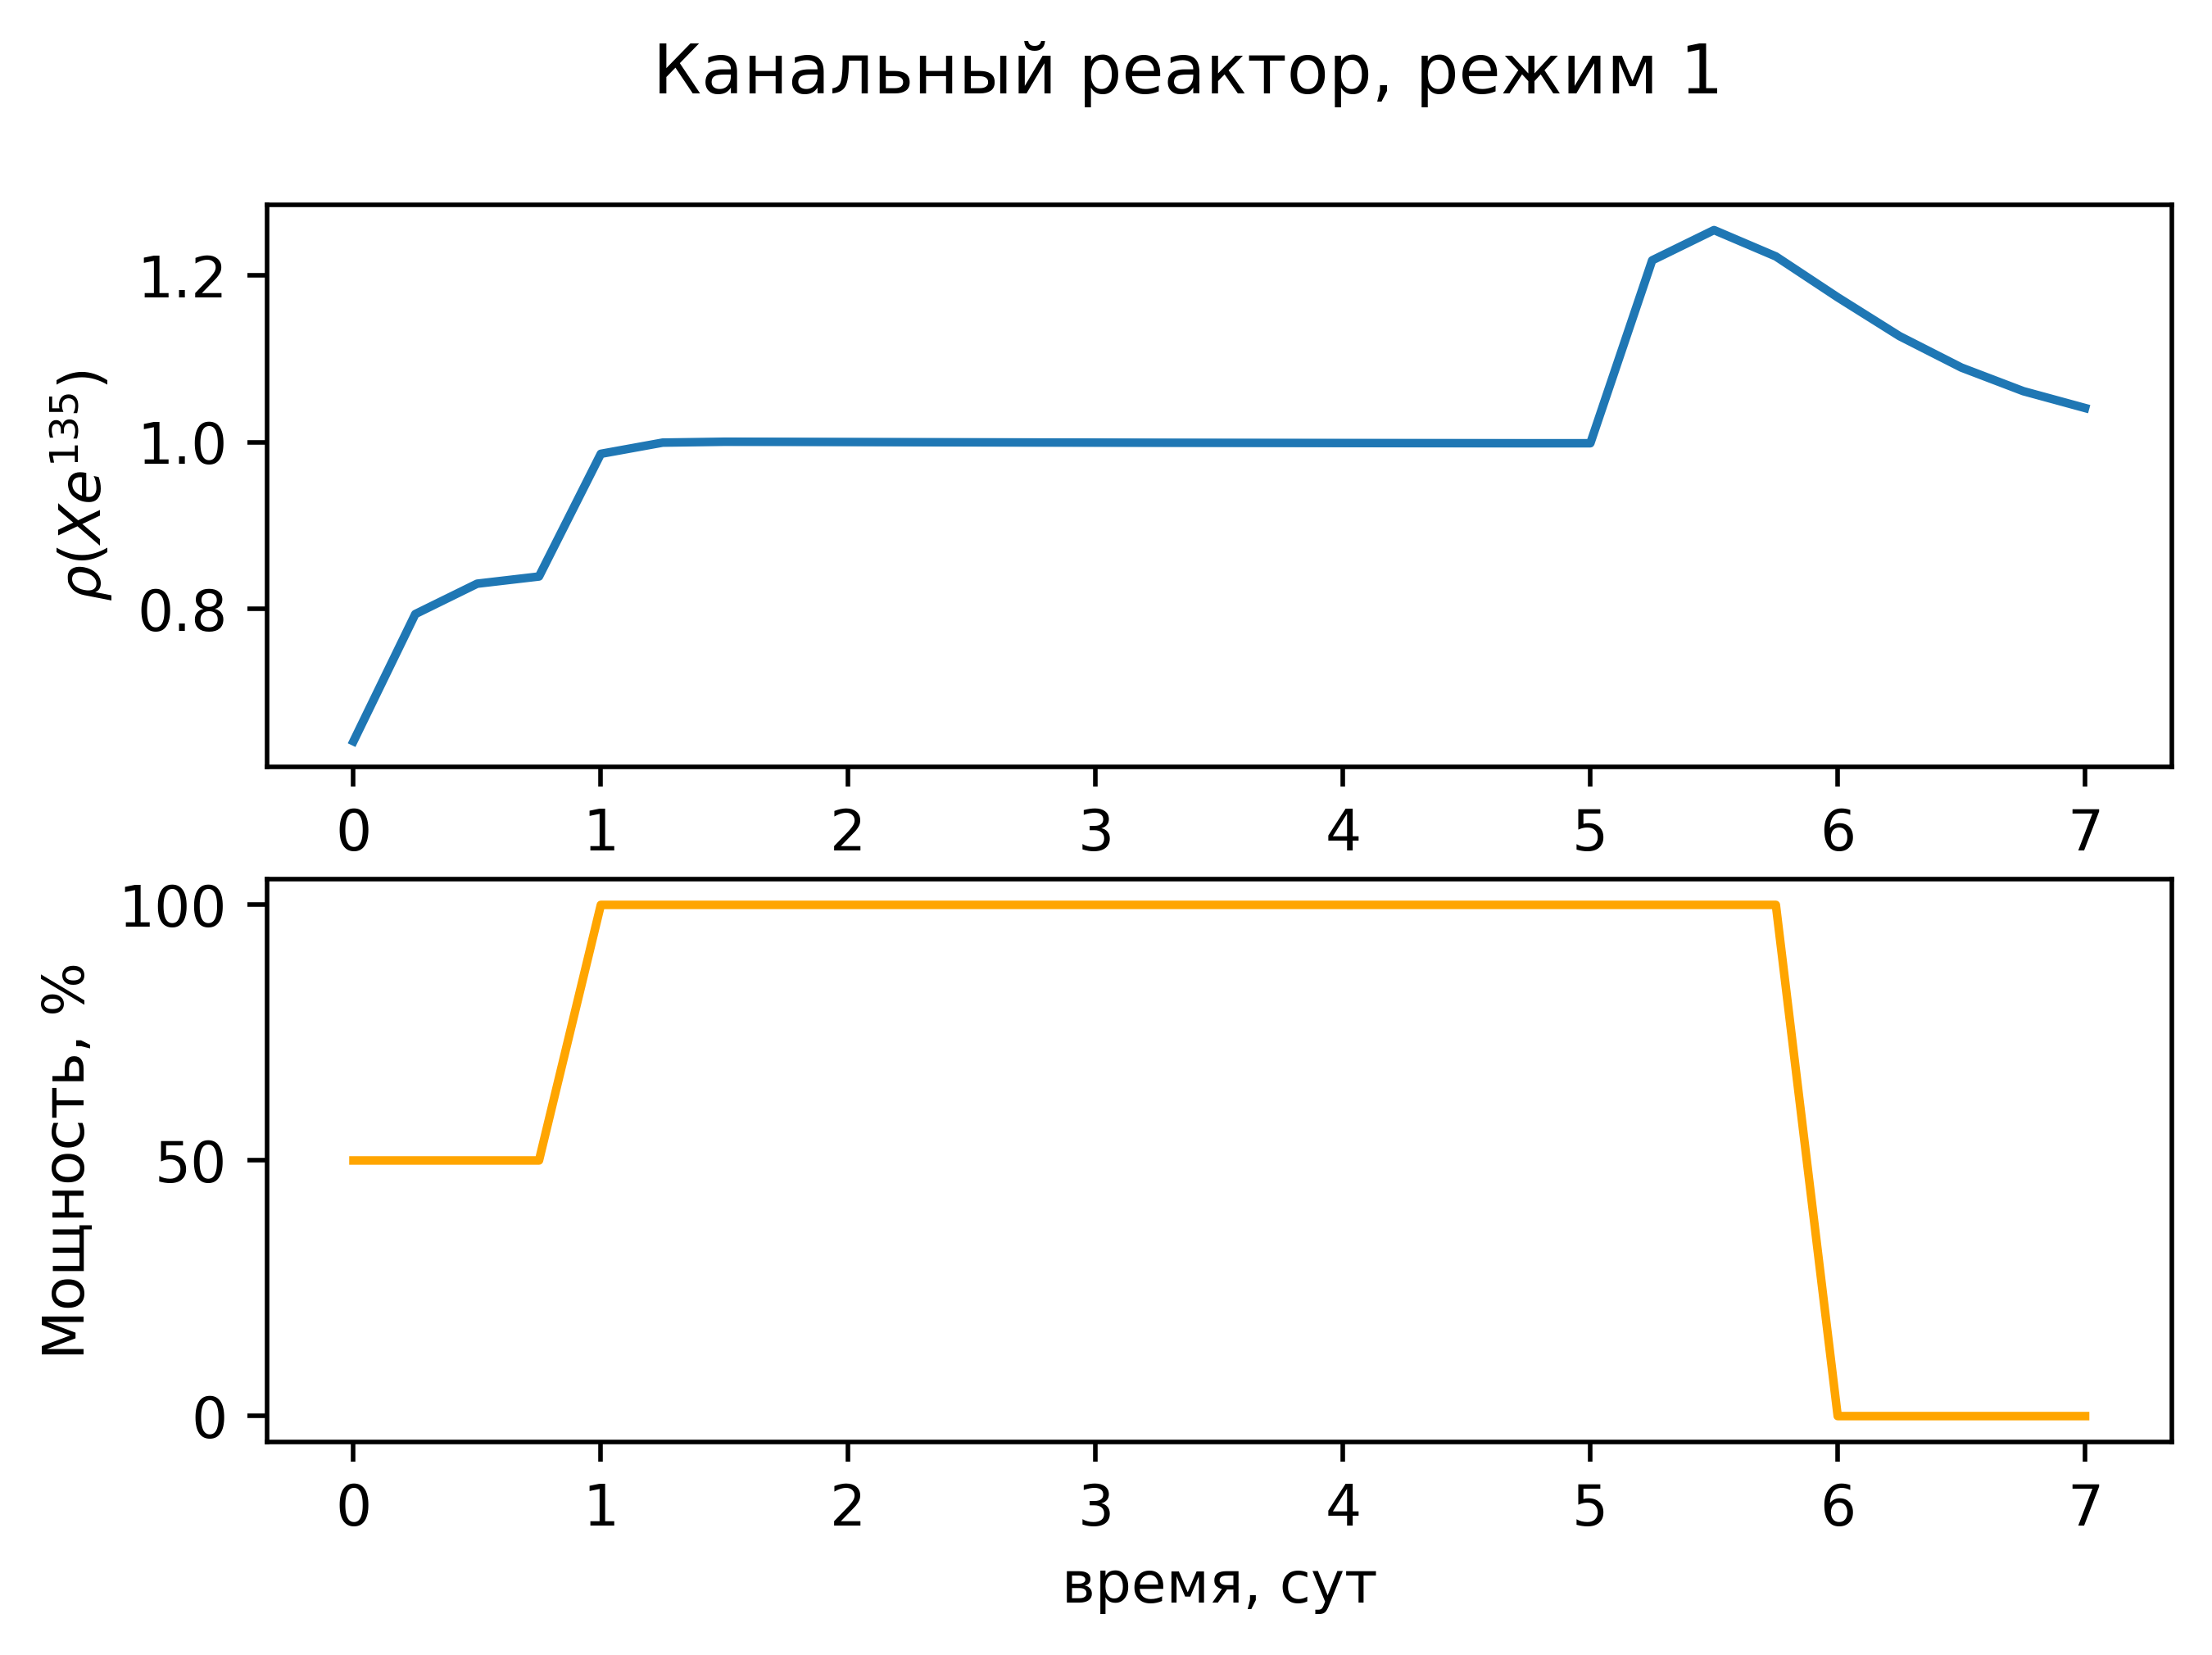

In [77]:
rbmk1 = rbmk_input()
F2 = 3e+4
rbmk1_after_stopping = rhoXeAfter(F2, rbmk1['ρ(xe35)'][19]) 
p1 = pd.concat((rbmk1, rbmk1_after_stopping), axis = 0, ignore_index=True)
p1['ρ(xe35)'] /= p1['ρ(xe35)'][8]
p1v = p1[::4]
p1v.index = range(8)
display(p1v.T)

fig, (ax1, ax2) = pl.subplots(2)
fig.suptitle('Канальный реактор, режим 1')
ax1.plot(p1.index/4, p1['ρ(xe35)'])
ax2.plot(p1.index/4, [50]*4+[100]*20+[0]*5, color='orange')
pl.xlabel('время, сут')
ax1.set_ylabel(r'$\rho(Xe^{135})$')
ax2.set_ylabel(r'Мощность, %')
fig.set_dpi(500)

**ВВЭР: Режим 2**

$q_v = 110,110,110,110,55$

,0,1,2,3,4,5,6,7
keff,0.809670,0.807230,0.80659,0.806290,0.806100,0.00000,0.00000,0.000000
ρ(xe35),0.388727,0.922395,1.00000,1.011582,0.828441,0.59571,0.81553,0.648798


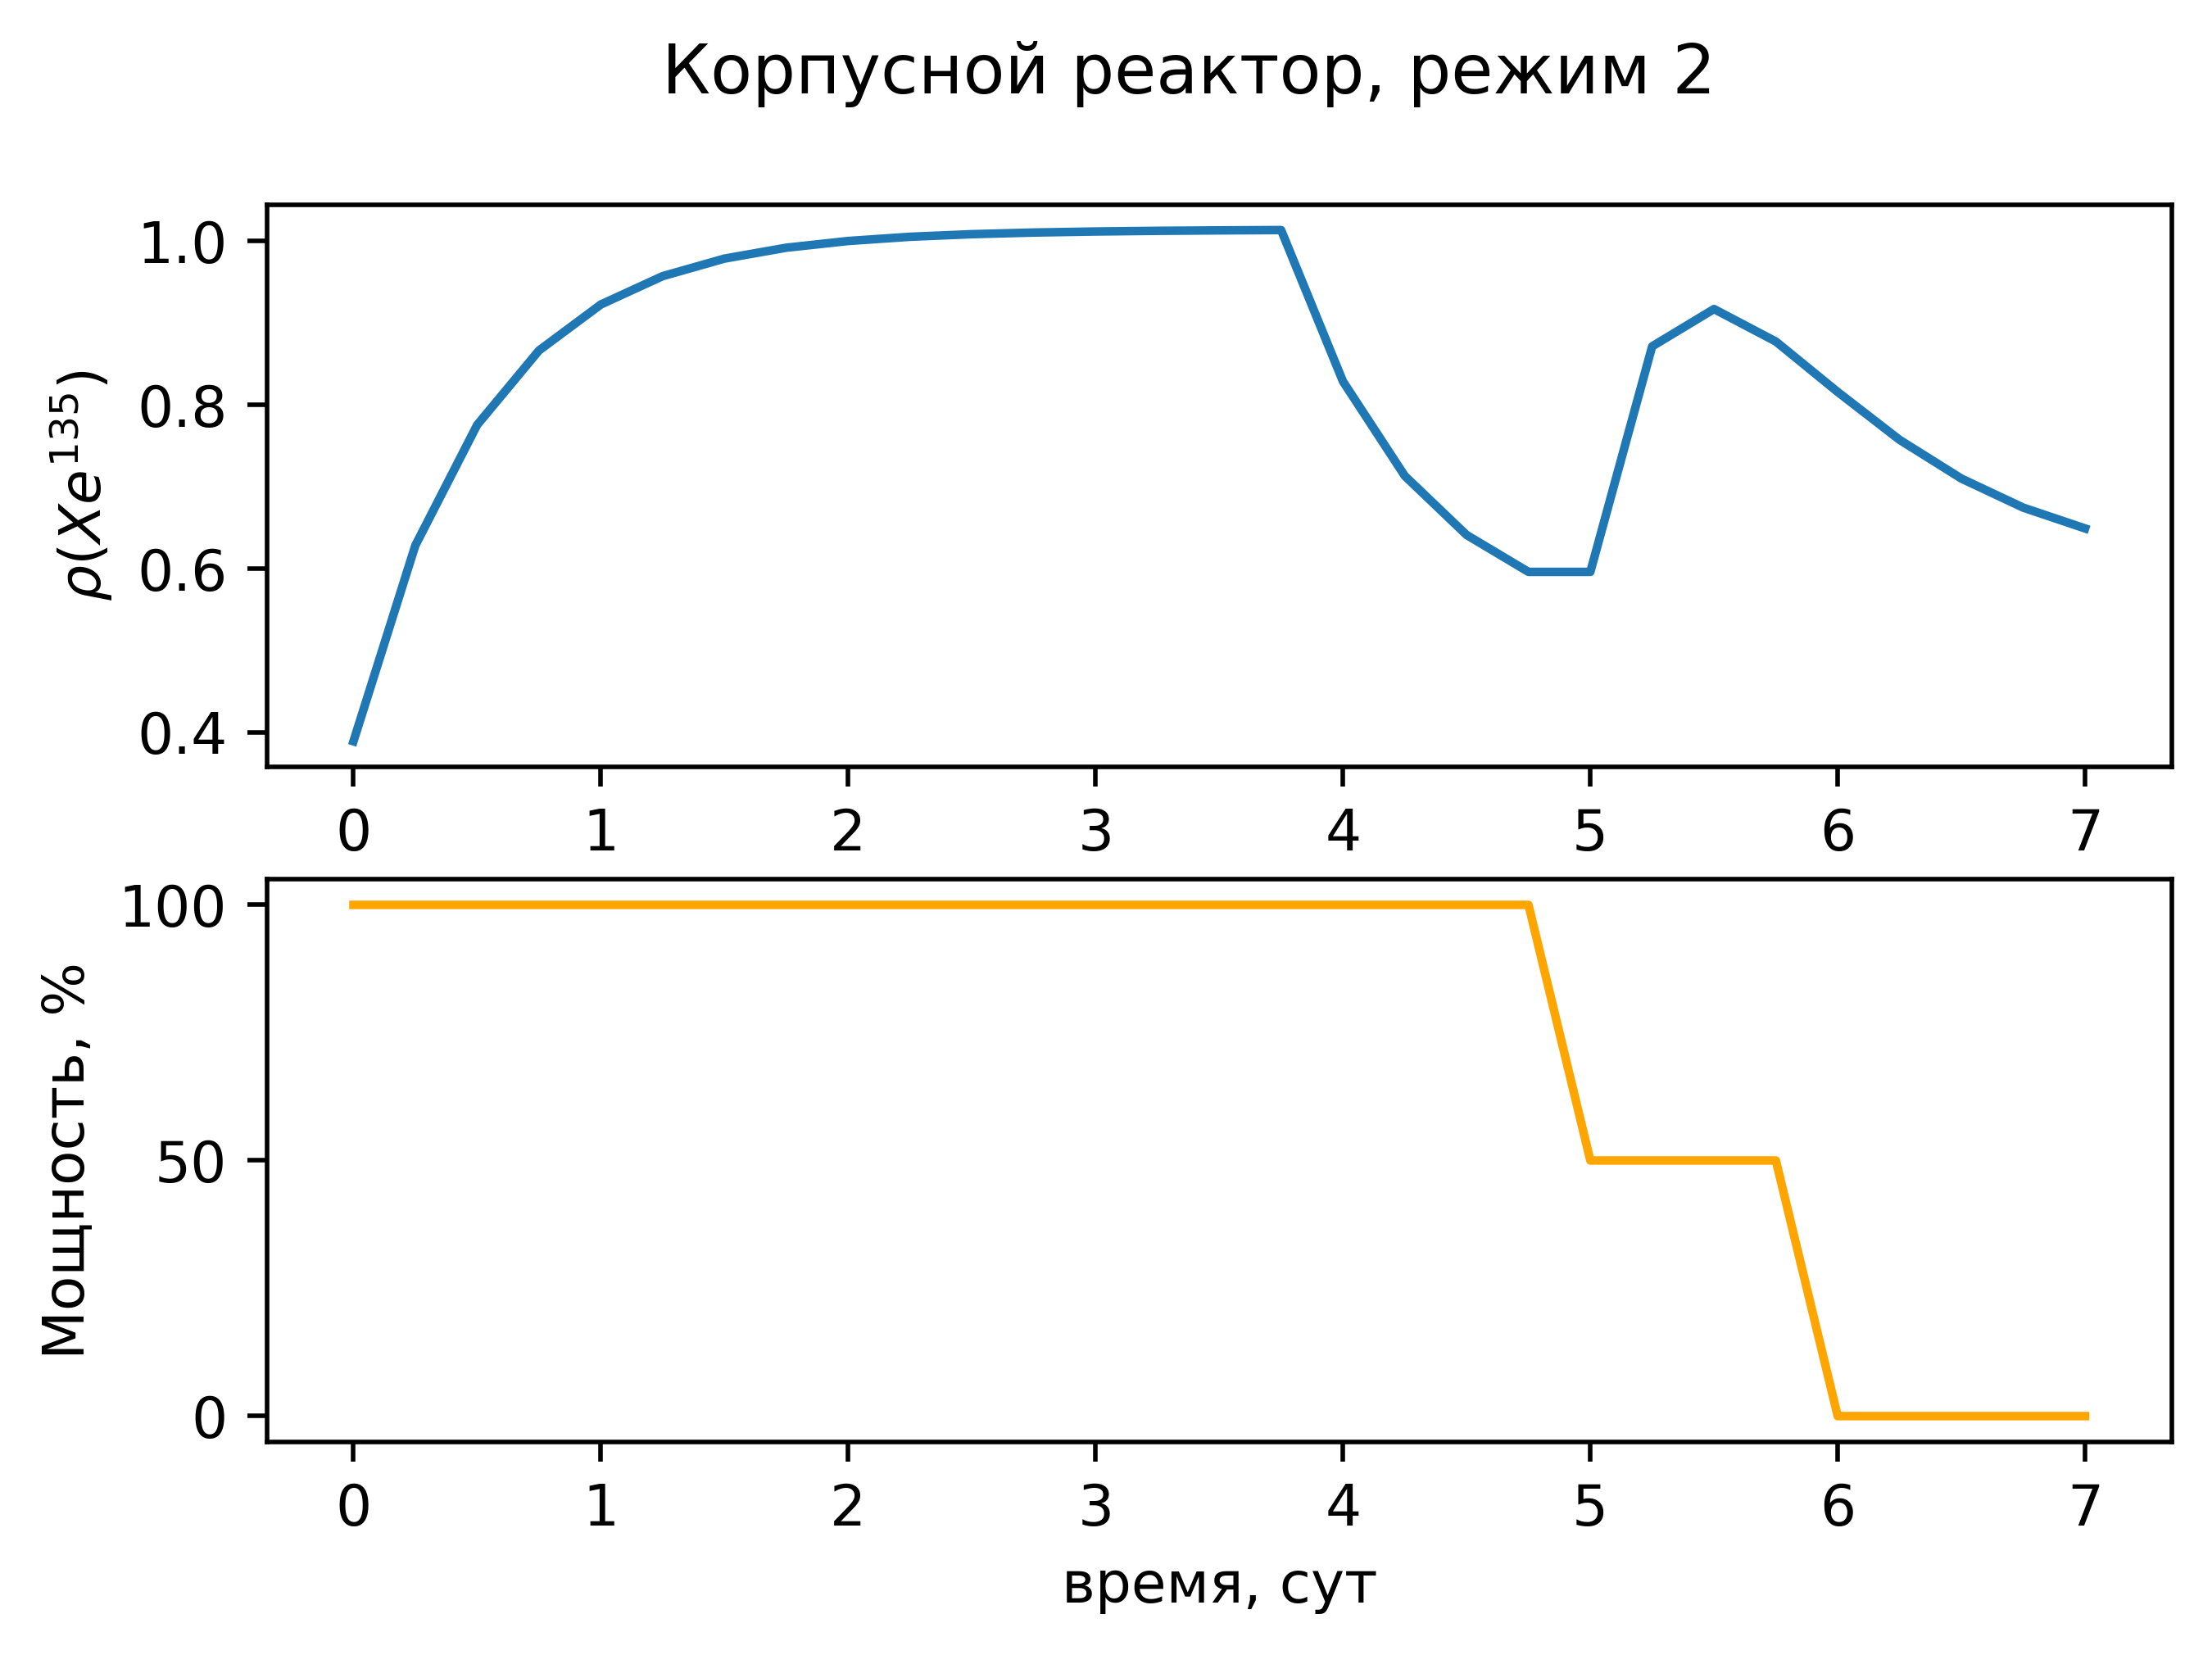

In [87]:
vver2 = vver_input()
F = F1/2
vver2_after_stopping = rhoXeAfter(F, vver2['ρ(xe35)'][19]) 
p01 = pd.concat((vver2, vver2_after_stopping), axis = 0, ignore_index=True)
p01['ρ(xe35)'] /= p01['ρ(xe35)'][8]
p01v = p01[::4]
p01v.index = range(8)
display(p01v.T)

fig, (ax1, ax2) = pl.subplots(2)
fig.suptitle('Корпусной реактор, режим 2')
ax1.plot(p01.index/4, p01['ρ(xe35)'])
ax2.plot(p01.index/4, [100]*20+[50]*4+[0]*5, color='orange')
pl.xlabel('время, сут')
ax1.set_ylabel(r'$\rho(Xe^{135})$')
ax2.set_ylabel(r'Мощность, %')

fig.set_dpi(500)


**РБМК: Режим 2**

$q_v=4.5,4.5,4.5,4.5,2.25$

,0,1,2,3,4,5,6,7
keff,1.450200,1.399800,1.3981,1.396300,1.394500,0.000000,0.000000,0.000000
ρ(xe35),0.909366,1.000832,1.0000,0.999401,0.878067,0.840808,0.928332,0.861946


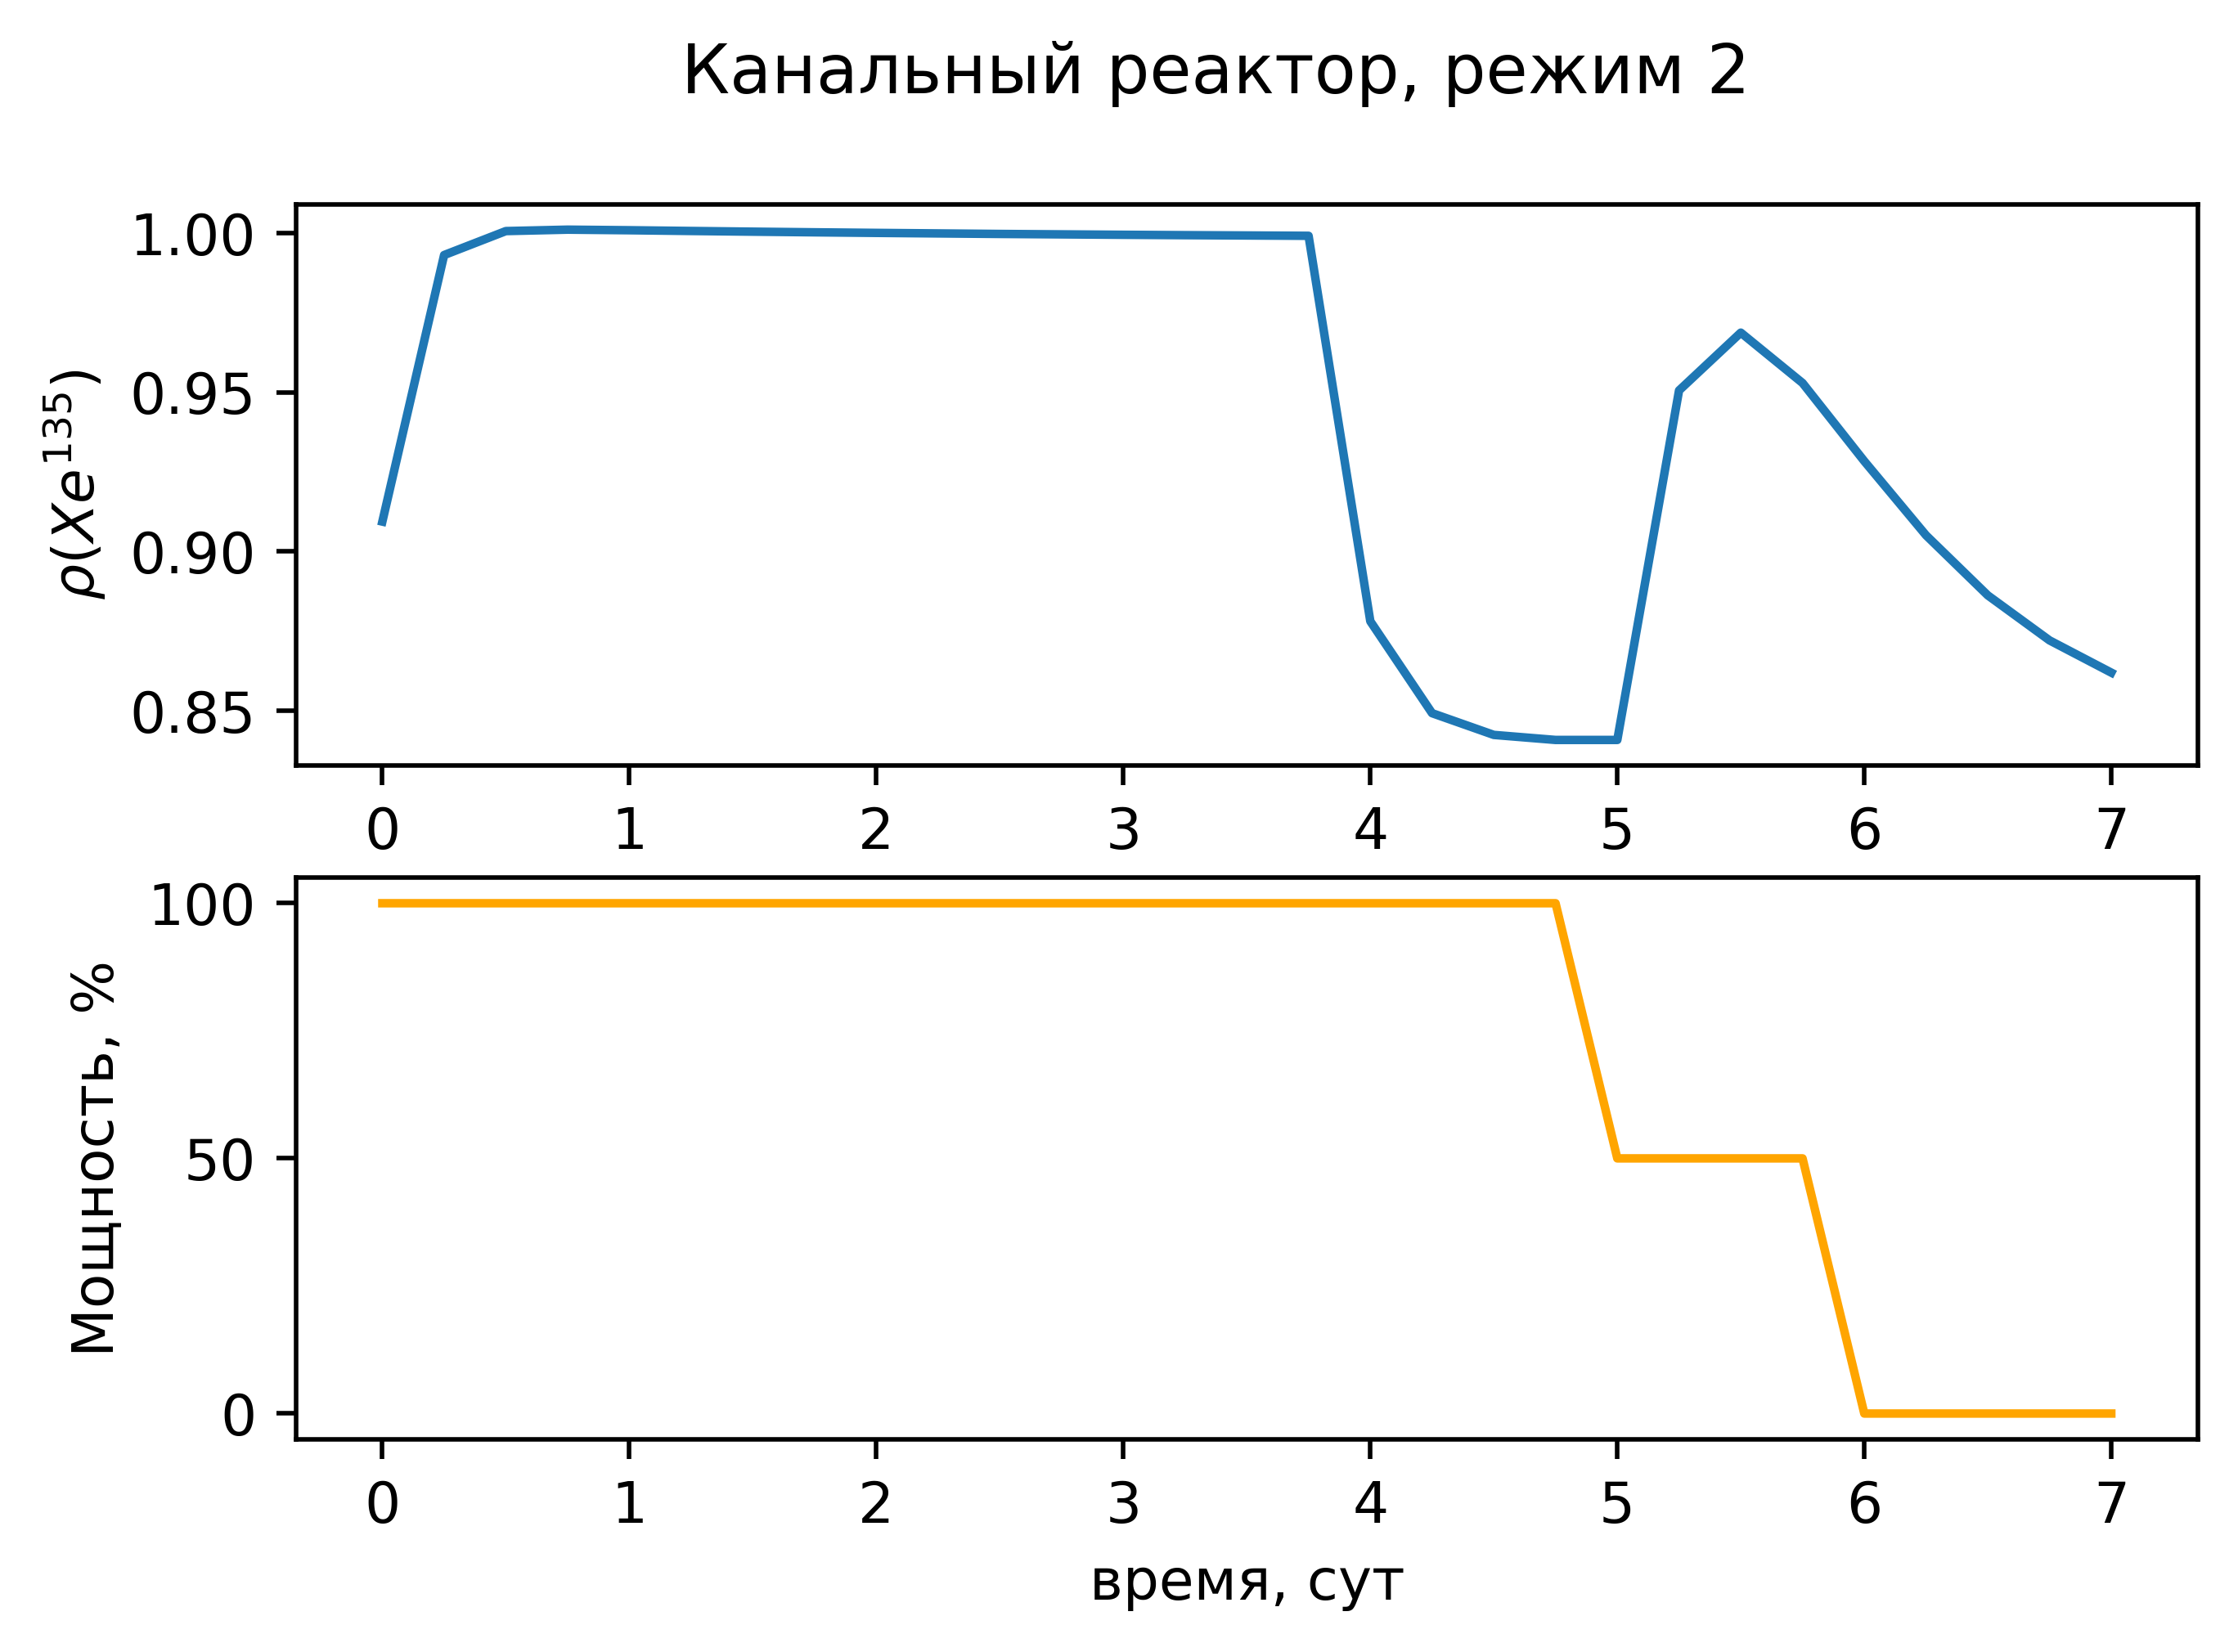

In [79]:
rbmk2 = rbmk_input()
F = F2/2
rbmk2_after_stopping = rhoXeAfter(F, rbmk2['ρ(xe35)'][19]) 
p11 = pd.concat((rbmk2, rbmk2_after_stopping), axis = 0, ignore_index=True)
p11['ρ(xe35)'] /= p11['ρ(xe35)'][8]
p11v = p11[::4]
p11v.index = range(8)
display(p11v.T)

fig, (ax1, ax2) = pl.subplots(2)
fig.suptitle('Канальный реактор, режим 2')
ax1.plot(p11.index/4, p11['ρ(xe35)'])
ax2.plot(p11.index/4, [100]*20+[50]*4+[0]*5, color='orange')
pl.xlabel('время, сут')
ax1.set_ylabel(r'$\rho(Xe^{135})$')
ax2.set_ylabel(r'Мощность, %')
fig.set_dpi(500)